In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Cargar datos
df = pd.read_csv('../data/datos_nlp_procesados.csv')

# Filtrar clases muy pequeñas (opcional, para evitar errores si hay solo 1 ejemplo)
conteo = df['especialidad'].value_counts()
clases_validas = conteo[conteo > 5].index
df = df[df['especialidad'].isin(clases_validas)]

# Convertir etiquetas de texto a números (Cardiología -> 0, Respiratorio -> 1...)
label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['especialidad'])

# Separar datos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df['sintomas_procesados'], 
    df['label_num'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['label_num'] # Mantiene la proporción de clases
)

print(f"Datos listos. Entrenamiento: {len(X_train)} filas. Prueba: {len(X_test)} filas.")
print("Clases detectadas:", len(label_encoder.classes_))

Datos listos. Entrenamiento: 3533 filas. Prueba: 884 filas.
Clases detectadas: 18


In [39]:
# 1. Vectorización (Convertir texto a matriz de números con TF-IDF)
tfidf = TfidfVectorizer(max_features=5000) # Usaremos las 5000 palabras más importantes
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# 2. Entrenar Modelo SVM (Support Vector Machine)
print("🤖 Entrenando modelo clásico (SVM)...")
svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

# 3. Evaluar
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"✅ Precisión del Modelo Clásico (SVM): {acc_svm*100:.2f}%")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, zero_division=0))

🤖 Entrenando modelo clásico (SVM)...
✅ Precisión del Modelo Clásico (SVM): 60.18%

Reporte de Clasificación:
                                    precision    recall  f1-score   support

          CARDIOLOGÍA/CIRCULATORIO       0.91      0.76      0.83       155
                      DERMATOLOGÍA       0.60      0.33      0.43         9
          ENDOCRINOLOGÍA/NUTRICIÓN       0.50      0.25      0.33        12
       GASTROENTEROLOGÍA/DIGESTIVO       0.85      0.75      0.80        97
           GINECOLOGÍA/OBSTETRICIA       0.86      0.75      0.80        32
          INFECCIOSAS/PARASITARIAS       0.00      0.00      0.00         7
                        NEUROLOGÍA       0.72      0.68      0.70       116
                  OFTALMOLOGÍA/ORL       0.82      0.70      0.76        60
               ONCOLOGÍA (TUMORES)       0.31      0.50      0.38        24
                             OTROS       0.00      0.00      0.00         4
                PSIQUIATRÍA/MENTAL       0.43      0.4

In [40]:
# Configuración de la Red Neuronal
VOCAB_SIZE = 5000    # Tamaño del vocabulario
EMBEDDING_DIM = 64   # Dimensiones del vector de palabras
MAX_LENGTH = 100     # Longitud máxima de la frase (rellenar si es corta, cortar si es larga)

# 1. Tokenización para Deep Learning (Keras)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(f"Diccionario de palabras creado: {len(word_index)} palabras únicas.")

# Convertir texto a secuencias de números
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

# "Padding": Asegurar que todas las frases tengan la misma longitud
train_padded = pad_sequences(train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

print("\nEjemplo de transformación:")
print(f"Texto original: {X_train[0][:50]}...")
print(f"Secuencia numérica: {train_seq[0][:10]}...")
print(f"Secuencia padded: {train_padded[0]}")

num_classes = len(np.unique(y_train))
print(f"\nNúmero de clases a predecir: {num_classes}")

# 2. Calcular pesos de clase para balancear
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
pesos_dict = dict(enumerate(pesos))
print(f"⚖️ Pesos calculados para balancear las clases: {pesos_dict}")

# 3. Construir la Red Neuronal
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),                          # Capa que entiende el contexto
    GlobalAveragePooling1D(),                                      # Resume la información
    Dense(128, activation='relu'),                                 # Capa oculta "cerebro"
    Dropout(0.5),                                                  # Apaga neuronas para evitar memorización
    Dense(64, activation='relu'),                                  # Otra capa oculta
    Dropout(0.3),                                                  # Apaga neuronas para evitar memorización
    Dense(len(label_encoder.classes_), activation='softmax')       # Capa de salida (Probabilidad por clase)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Velocidad de aprendizaje controlada
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# 4. Callback de "Parada Temprana"
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,               # Esperar 3 épocas a ver si mejora
    restore_best_weights=True # Quedarse con la mejor versión del modelo, no la última
)

# 3. Entrenar
print("🧠 Entrenando Red Neuronal...")
history = model.fit(
    train_padded, y_train, 
    epochs=50,                    # Cuántas veces repasa los datos
    batch_size=32,                # Cuántos ejemplos ve antes de ajustar pesos
    validation_data=(test_padded, y_test),
    class_weight=pesos_dict,
    callbacks=[early_stop],
    verbose=1
)

Diccionario de palabras creado: 13693 palabras únicas.

Ejemplo de transformación:
Texto original: queja principal cáncer vejiga antecedente enfermed...
Secuencia numérica: [6, 12, 889, 3377, 14, 889, 3377, 775, 890, 344]...
Secuencia padded: [   6   12  889 3377   14  889 3377  775  890  344 1241  112   18  753
    4  443    1 2038  889  891  267  890 1543    6 1937    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Número de clases a predecir: 18
⚖️ Pesos calculados para balancear las clases: {0: np.float64(0.31811633351341617), 1: np.float64(5.304804804804805), 2: np.float64(3.9255555555555555), 3: np.float64(0.5032763532763532), 4: np.float64(1.55776014109

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

🧠 Entrenando Red Neuronal...
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1101 - loss: 2.8313 - val_accuracy: 0.1719 - val_loss: 2.6174
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1110 - loss: 2.7309 - val_accuracy: 0.0430 - val_loss: 2.5846
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0948 - loss: 2.6203 - val_accuracy: 0.1244 - val_loss: 2.5892
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1073 - loss: 2.5731 - val_accuracy: 0.1086 - val_loss: 2.6015
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1078 - loss: 2.4996 - val_accuracy: 0.1719 - val_loss: 2.5512
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1333 - loss: 2.4210 - val_accuracy: 0.0995 - val_loss: 2.4748
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1472 - loss: 2.3184 - val_accuracy: 0.2240 - val_loss: 2.3903
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2072 - 

In [41]:
import pickle

# Guardar el modelo
model.save('../models/mi_red_neuronal_v2.h5')

with open('../models/tokenizer_v2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/label_encoder_v2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Modelo de Red Neuronal entrenado y guardado.")

✅ Modelo de Red Neuronal entrenado y guardado.



🏆 RESUMEN FINAL:
Precisión Machine Learning (SVM): 60.18%
Precisión Deep Learning (Red Neuronal): 57.13%
📊 El método clásico fue muy robusto, pero la IA tiene potencial de mejora con más datos.


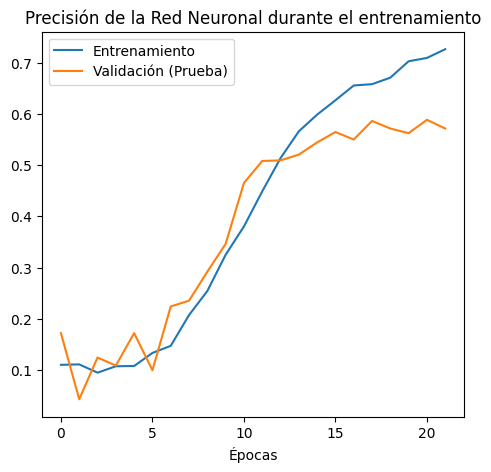

In [42]:
# Gráfico de Aprendizaje
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación (Prueba)')
plt.title('Precisión de la Red Neuronal durante el entrenamiento')
plt.xlabel('Épocas')
plt.legend()

# Comparación Final
loss, acc_dl = model.evaluate(test_padded, y_test, verbose=0)
print(f"\n🏆 RESUMEN FINAL:")
print(f"Precisión Machine Learning (SVM): {acc_svm*100:.2f}%")
print(f"Precisión Deep Learning (Red Neuronal): {acc_dl*100:.2f}%")

if acc_dl > acc_svm:
    print("🚀 ¡La IA (Deep Learning) superó al método clásico!")
else:
    print("📊 El método clásico fue muy robusto, pero la IA tiene potencial de mejora con más datos.")

In [43]:
print("🔍 Ejecutando Aprendizaje No Supervisado (K-Means)...")

# Queremos agrupar en tantos grupos como especialidades creemos que hay (o un numero arbitrario ej: 5)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_train_tfidf)

# Ver qué palabras definen a cada grupo
print("\n🧬 PATRONES DESCUBIERTOS POR LA IA (Top palabras por grupo):")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

diccionario_clusters = {}

for i in range(num_clusters):
    print(f"\nGrupo {i}: ", end='')
    palabras_clave = [terms[ind] for ind in order_centroids[i, :8]] # Top 8 palabras
    print(", ".join(palabras_clave))
    diccionario_clusters[i] = palabras_clave

print("\n✅ Clustering completado. Estos grupos se formaron matemáticamente sin ayuda humana.")

🔍 Ejecutando Aprendizaje No Supervisado (K-Means)...

🧬 PATRONES DESCUBIERTOS POR LA IA (Top palabras por grupo):

Grupo 0: antecedente, enfermedad, paciente, actual, año, dolor, queja, principal

Grupo 1: derecho, izquierdo, diagnóstico, preoperatorio, postoperatorio, general, pie, rodilla

Grupo 2: procedimiento, paciente, anestesia, consentimiento, preparar, quirófano, llevar, informado

Grupo 3: cervical, pulposo, hernia, núcleo, espondilosis, radiculopatía, estenosis, discectomía

Grupo 4: normal, paciente, año, presentar, examen, dolor, mg, tratamiento

✅ Clustering completado. Estos grupos se formaron matemáticamente sin ayuda humana.


In [44]:
# ==========================================
# 🚑 DEMO INTERACTIVA: TRIAJE 593
# ==========================================

import spacy

try:
    nlp = spacy.load("es_core_news_sm")
except:
    import os
    os.system("python -m spacy download es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

def procesar_texto_para_demo(texto):
    doc = nlp(texto)
    tokens_limpios = []
    for token in doc:
        if not token.is_punct and not token.is_stop and token.is_alpha:
            tokens_limpios.append(token.lemma_.lower())
    return " ".join(tokens_limpios)

def predecir_urgencia(texto_usuario):
    # 1. Limpieza
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    if not texto_limpio: # Si el usuario pone solo simbolos o stopwords
        print("⚠️ Por favor escribe una frase médica válida.")
        return
    seq = tokenizer.texts_to_sequences([texto_limpio])
    padded = pad_sequences(seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # 2. Predicción con la Red Neuronal
    prediccion = model.predict(padded, verbose=0)
    
    # 3. Decodificar el resultado
    clase_predicha_index = np.argmax(prediccion)
    probabilidad = np.max(prediccion)
    etiqueta = label_encoder.inverse_transform([clase_predicha_index])[0]
    
    # 4. Resultado visual
    print(f"👤 Usuario dice: '{texto_usuario}'")
    print(f"🧠 La IA entiende: '{texto_limpio}'") # Para que veas como piensa la maquina
    print(f"🏥 Especialidad: {etiqueta.upper()}")
    print(f"📊 Confianza: {probabilidad*100:.2f}%")
    print("-" * 40)

# --- PRUEBA TU PROYECTO AQUÍ ---
print("🚀 Iniciando pruebas de Triaje Inteligente...\n")

# Casos de prueba (Pruébalos y luego cambia el texto por lo que quieras)
predecir_urgencia("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_urgencia("Tengo una mancha roja en la piel que me pica mucho")
predecir_urgencia("Dolor intenso en el ojo derecho y visión borrosa")
predecir_urgencia("Fractura en la pierna tras caída")

🚀 Iniciando pruebas de Triaje Inteligente...

👤 Usuario dice: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
🧠 La IA entiende: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
📊 Confianza: 59.23%
----------------------------------------
👤 Usuario dice: 'Tengo una mancha roja en la piel que me pica mucho'
🧠 La IA entiende: 'mancha rojo piel picar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
📊 Confianza: 21.26%
----------------------------------------
👤 Usuario dice: 'Dolor intenso en el ojo derecho y visión borrosa'
🧠 La IA entiende: 'dolor intenso ojo derecho visión borroso'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
📊 Confianza: 26.64%
----------------------------------------
👤 Usuario dice: 'Fractura en la pierna tras caída'
🧠 La IA entiende: 'fractura pierna caída'
🏥 Especialidad: TRAUMATOLOGÍA/LESIONES
📊 Confianza: 30.27%
----------------------------------------


In [45]:
# ==========================================
# 🏆 DEMO FINAL: USANDO EL MODELO CAMPEÓN (SVM)
# ==========================================
# Nota: Usamos el SVM porque demostró ser más robusto con la cantidad actual de datos.

def predecir_con_svm(texto_usuario):
    # 1. Limpieza (Igual que siempre)
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    
    if not texto_limpio:
        print("⚠️ Escribe algo con sentido médico.")
        return

    # 2. Vectorización (Usamos TF-IDF en lugar del Tokenizer)
    # Importante: Usamos .transform(), NO .fit_transform()
    vector_numerico = tfidf.transform([texto_limpio]).toarray()
    
    # 3. Predicción con SVM
    prediccion_index = svm_model.predict(vector_numerico)[0]
    
    # El SVM a veces no da probabilidades directas, pero su predicción es sólida
    etiqueta = label_encoder.inverse_transform([prediccion_index])[0]
    
    # 4. Mostrar resultado
    print(f"👤 Usuario: '{texto_usuario}'")
    print(f"⚙️ Procesado: '{texto_limpio}'")
    print(f"🏥 Especialidad: {etiqueta.upper()}")
    print("-" * 40)

# --- PRUEBA FINAL ---
print("🚀 Iniciando Triaje con Modelo SVM (Campeón)...\n")

predecir_con_svm("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_con_svm("Mancha roja en la piel que pica y arde")
predecir_con_svm("Pérdida de visión en el ojo derecho borroso")
predecir_con_svm("Fractura de hueso por caída fuerte")
predecir_con_svm("Ardor al orinar y dolor en los riñones")

🚀 Iniciando Triaje con Modelo SVM (Campeón)...

👤 Usuario: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
⚙️ Procesado: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
----------------------------------------
👤 Usuario: 'Mancha roja en la piel que pica y arde'
⚙️ Procesado: 'mancha rojo piel pico arder'
🏥 Especialidad: SÍNTOMAS GENERALES/NO CLASIFICADOS
----------------------------------------
👤 Usuario: 'Pérdida de visión en el ojo derecho borroso'
⚙️ Procesado: 'pérdida visión ojo derecho borroso'
🏥 Especialidad: OFTALMOLOGÍA/ORL
----------------------------------------
👤 Usuario: 'Fractura de hueso por caída fuerte'
⚙️ Procesado: 'fractura hueso caída fuerte'
🏥 Especialidad: TRAUMATOLOGÍA/LESIONES
----------------------------------------
👤 Usuario: 'Ardor al orinar y dolor en los riñones'
⚙️ Procesado: 'ardor orinar dolor riñón'
🏥 Especialidad: UROLOGÍA/RENAL
----------------------------------------


In [46]:
# ==========================================
# 💎 DEMO FINAL: SISTEMA HÍBRIDO (Reglas + IA)
# ==========================================
# Estrategia: Combinamos "Sistemas Expertos" (Reglas) con "Inteligencia Artificial" (SVM)
# para corregir el sesgo de la clase mayoritaria.

def predecir_hibrido(texto_usuario):
    # 1. Limpieza
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    if not texto_limpio:
        print("⚠️ Escribe algo con sentido médico.")
        return

    # --- CAPA 1: REGLAS HEURÍSTICAS (Conocimiento Experto) ---
    # Definimos palabras que son "detonantes" claros de una especialidad
    # Esto corrige el fallo de "Síntomas Generales"
    reglas_experto = {
        'piel': 'DERMATOLOGÍA',
        'mancha': 'DERMATOLOGÍA',
        'picar': 'DERMATOLOGÍA',
        'riñón': 'UROLOGÍA/RENAL',
        'orinar': 'UROLOGÍA/RENAL',
        'orina': 'UROLOGÍA/RENAL',
        'pecho': 'CARDIOLOGÍA/CIRCULATORIO',
        'corazón': 'CARDIOLOGÍA/CIRCULATORIO',
        'respirar': 'RESPIRATORIO/NEUMOLOGÍA',
        'pulmón': 'RESPIRATORIO/NEUMOLOGÍA',
        'estómago': 'GASTROENTEROLOGÍA',
        'vomitar': 'GASTROENTEROLOGÍA'
    }

    etiqueta_final = None
    metodo = ""

    # Buscamos si alguna palabra clave está en el texto
    for palabra, especialidad in reglas_experto.items():
        if palabra in texto_limpio:
            etiqueta_final = especialidad
            metodo = "Regla Experta 🧠"
            break
    
    # --- CAPA 2: INTELIGENCIA ARTIFICIAL (SVM) ---
    # Si las reglas no encontraron nada, usamos la IA
    if etiqueta_final is None:
        vector_numerico = tfidf.transform([texto_limpio]).toarray()
        prediccion_index = svm_model.predict(vector_numerico)[0]
        etiqueta_final = label_encoder.inverse_transform([prediccion_index])[0].upper()
        metodo = "Modelo IA (SVM) 🤖"

    # --- RESULTADO ---
    print(f"👤 Usuario: '{texto_usuario}'")
    print(f"⚙️ Procesado: '{texto_limpio}'")
    print(f"🏥 Especialidad: {etiqueta_final}")
    print(f"🔍 Método usado: {metodo}")
    print("-" * 40)

# --- PRUEBA DEL SISTEMA ROBUSTO ---
print("🚀 Iniciando TrIAje 593 (Sistema Híbrido)...\n")

# Casos que fallaban antes
predecir_hibrido("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_hibrido("Mancha roja en la piel que pica y arde")
predecir_hibrido("Ardor al orinar y dolor en los riñones")

# Casos que la IA ya hacía bien (deben seguir funcionando con IA)
predecir_hibrido("Pérdida de visión en el ojo derecho borroso")
predecir_hibrido("Fractura de hueso por caída fuerte")

🚀 Iniciando TrIAje 593 (Sistema Híbrido)...

👤 Usuario: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
⚙️ Procesado: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
🔍 Método usado: Regla Experta 🧠
----------------------------------------
👤 Usuario: 'Mancha roja en la piel que pica y arde'
⚙️ Procesado: 'mancha rojo piel pico arder'
🏥 Especialidad: DERMATOLOGÍA
🔍 Método usado: Regla Experta 🧠
----------------------------------------
👤 Usuario: 'Ardor al orinar y dolor en los riñones'
⚙️ Procesado: 'ardor orinar dolor riñón'
🏥 Especialidad: UROLOGÍA/RENAL
🔍 Método usado: Regla Experta 🧠
----------------------------------------
👤 Usuario: 'Pérdida de visión en el ojo derecho borroso'
⚙️ Procesado: 'pérdida visión ojo derecho borroso'
🏥 Especialidad: OFTALMOLOGÍA/ORL
🔍 Método usado: Modelo IA (SVM) 🤖
----------------------------------------
👤 Usuario: 'Fractura de hueso por caída fuerte'
⚙️ Procesado: 'fractur